In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pyarrow as pa
import pyarrow.parquet as pq

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from functions import (
    read_first_n_rows, # Function to read parquet files
    analyze_target_correlation # Correlation analysis function
)


Data has +1M records... First let's work on 500k and then validate results

* Parecen haber variables categoricas representadas con números

In [3]:
# Read the first 500,000 rows from train.parquet, excluding 'weight' column
# First, let's get all columns except 'weight'
pf = pq.ParquetFile("train.parquet")
all_columns = pf.schema.names
columns_to_load = [col for col in all_columns if col != ['weight', "id"]]

train_sample = read_first_n_rows("train.parquet", n=500_000, columns=columns_to_load)

# Create two new variables: y_target and features (rest of columns)
y_target = train_sample['y_target'].copy()
X_features = train_sample.drop(columns=['y_target']).copy()

# Count numerical vs categorical columns in the train set
num_cols = train_sample.head(10).select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train_sample.head(10).select_dtypes(exclude=[np.number]).columns.tolist()
print("Shape", train_sample.shape)
print(f"Numerical columns: {len(num_cols)}")
print("Categorical:", cat_cols)
print(f"\ny_target shape: {y_target.shape}")
print(f"X_features shape: {X_features.shape}")

display(train_sample.head(10))

Shape (500000, 93)
Numerical columns: 89
Categorical: ['id', 'code', 'sub_code', 'sub_category']

y_target shape: (500000,)
X_features shape: (500000, 92)


,id,code,sub_code,sub_category,horizon,ts_index,feature_a,feature_b,feature_c,feature_d,...,feature_bz,feature_ca,feature_cb,feature_cc,feature_cd,feature_ce,feature_cf,feature_cg,feature_ch,y_target
0,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__25__89,W2MW3G2L,J0G2B0KU,PZ9S1Z4V,25,89,29,16.364093,7.464023,5.966933,...,-0.058543,-0.001686,-0.105328,-0.005045,NaN,-0.133697,2.849819,0.112068,1,-0.551324
1,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__1__89,W2MW3G2L,J0G2B0KU,PZ9S1Z4V,1,89,53,2.858806,5.050617,15.906651,...,-0.058543,-0.001686,-0.105328,-0.005045,NaN,-0.133697,2.849819,0.112068,1,-0.315583
2,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__3__89,W2MW3G2L,J0G2B0KU,PZ9S1Z4V,3,89,51,9.585452,1.076268,9.004147,...,-0.058543,-0.001686,-0.105328,-0.005045,NaN,-0.133697,2.849819,0.112068,1,-0.362894
3,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__10__89,W2MW3G2L,J0G2B0KU,PZ9S1Z4V,10,89,44,8.840588,15.034634,4.170780,...,-0.058543,-0.001686,-0.105328,-0.005045,NaN,-0.133697,2.849819,0.112068,1,-0.667023
4,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__25__90,W2MW3G2L,J0G2B0KU,PZ9S1Z4V,25,90,28,2.303825,7.696209,12.896100,...,-0.059625,-0.001622,-0.103809,-0.005135,NaN,-0.174660,2.738606,0.109204,1,-0.437398
5,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__10__90,W2MW3G2L,J0G2B0KU,PZ9S1Z4V,10,90,43,7.670046,13.530307,6.742442,...,-0.059625,-0.001622,-0.103809,-0.005135,NaN,-0.174660,2.738606,0.109204,1,-0.242618
6,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__3__90,W2MW3G2L,J0G2B0KU,PZ9S1Z4V,3,90,50,15.530394,0.345051,5.408604,...,-0.059625,-0.001622,-0.103809,-0.005135,NaN,-0.174660,2.738606,0.109204,1,-0.112007
7,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__1__90,W2MW3G2L,J0G2B0KU,PZ9S1Z4V,1,90,52,3.087222,1.252656,2.631384,...,-0.059625,-0.001622,-0.103809,-0.005135,NaN,-0.174660,2.738606,0.109204,1,0.023809
8,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__10__91,W2MW3G2L,J0G2B0KU,PZ9S1Z4V,10,91,42,5.503506,16.311692,7.548230,...,-0.058802,-0.001714,-0.104448,-0.005063,NaN,-0.048834,2.807526,0.107697,1,-0.369128
9,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__25__91,W2MW3G2L,J0G2B0KU,PZ9S1Z4V,25,91,27,13.164843,4.948078,1.252419,...,-0.058802,-0.001714,-0.104448,-0.005063,NaN,-0.048834,2.807526,0.107697,1,-1.037938


## Exploratory Data Analysis

### Identifying efficiently discrete and non-discrete numerical values

**Amount of unique labels by column:** Helps in order to know which features are categorical or not as well.

The ones that could be categorical may be:


In [ ]:
# Create table of unique value counts for all columns, sorted from highest to lowest
unique_counts = {col: len(train_sample[col].drop_duplicates()) for col in train_sample.columns}
unique_df = pd.DataFrame(list(unique_counts.items()), columns=['Column', 'Unique Count'])
unique_df = unique_df.sort_values(by='Unique Count', ascending=True).reset_index(drop=True)
display(unique_df.iloc[:50])  # Display top 20 columns with highest unique counts

,Column,Unique Count
0,code,2
1,horizon,4
2,sub_category,5
3,feature_ch,10
4,sub_code,177
5,feature_a,214
6,feature_w,413
7,feature_x,713
8,feature_o,955
9,feature_y,1030


### Null Values and behaviour for every column and each unique id

**Key Observations:** It can be seen that there are very little of null value amounts for the sub_code column... Which seems to be a good indicator on how the data is categorized

=== Columns with >= 10000 null values ===
Total columns: 9

feature_by    120996
feature_at    120987
feature_cd     68080
feature_ay     68060
feature_aw     29585
feature_bz     29585
feature_al     20363
feature_ce     13164
feature_cf     12888
dtype: int64


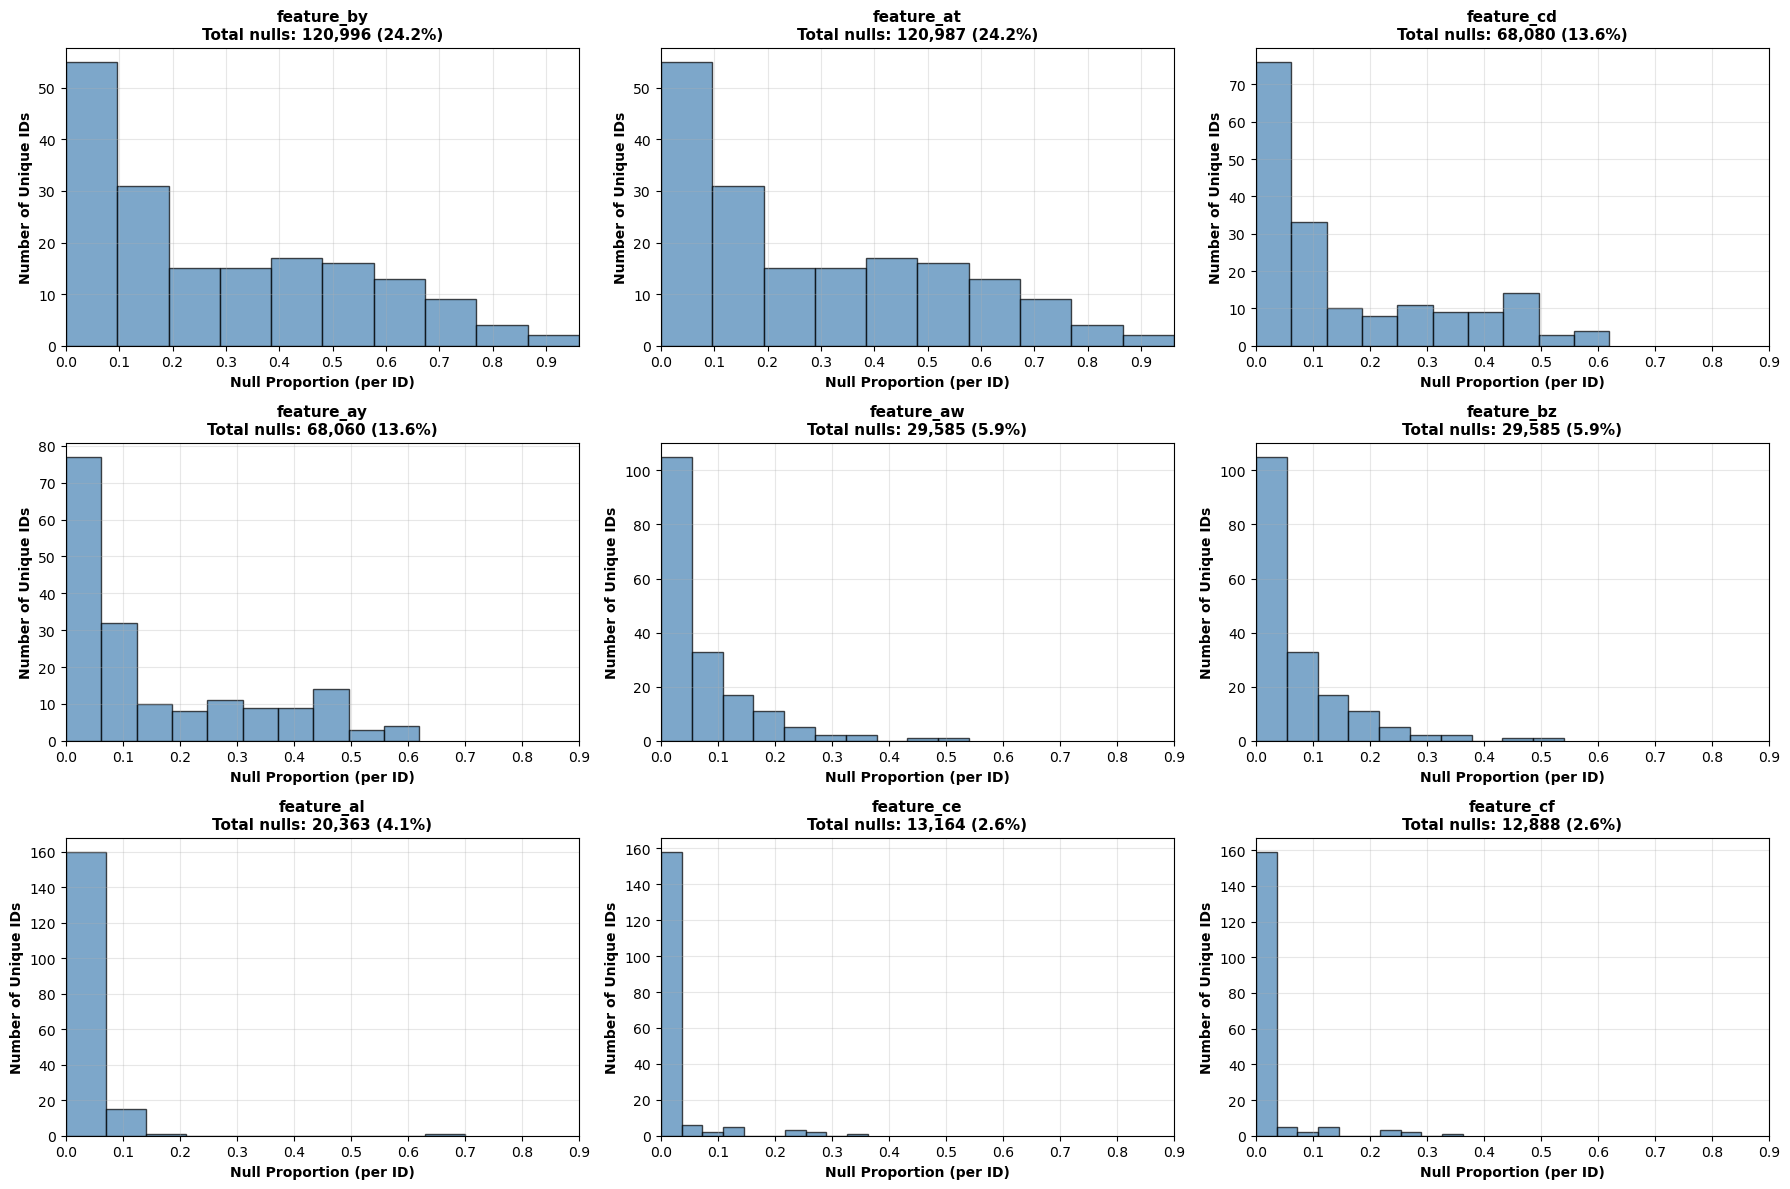

In [74]:
# Get columns with null values >= 10000
null_counts = train_sample.isnull().sum()
high_null_columns = null_counts[null_counts >= 10000].sort_values(ascending=False)

print(f"=== Columns with >= 10000 null values ===")
print(f"Total columns: {len(high_null_columns)}\n")
print(high_null_columns)

# Create histogram distributions for each column showing null proportion by ID
n_cols = len(high_null_columns)
n_rows = (n_cols + 2) // 3  # 3 columns per row
fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 4))
axes = axes.flatten() if n_cols > 1 else [axes]

for idx, col_name in enumerate(high_null_columns.index):
    # Calculate null proportion by ID for this specific column
    # For each unique ID, calculate: (null count for this column) / (total records for that ID)
    col_null_by_id = train_sample[col_name].isnull().groupby(train_sample["sub_code"]).sum()
    total_records_by_id = train_sample.groupby("sub_code").size()
    
    # Calculate proportion: null_count / total_records for this column
    col_null_proportion = (col_null_by_id / total_records_by_id).sort_values(ascending=False)
    
    # Plot histogram of null proportions across IDs (x-axis fitted to actual data range)
    axes[idx].hist(col_null_proportion, bins=10, alpha=0.7, color='steelblue', edgecolor='black')
    axes[idx].set_xlabel('Null Proportion (per ID)', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Number of Unique IDs', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'{col_name}\nTotal nulls: {high_null_columns[col_name]:,} ({high_null_columns[col_name]/len(train_sample)*100:.1f}%)', 
                       fontsize=11, fontweight='bold')
    axes[idx].set_xlim(col_null_proportion.min(), col_null_proportion.max())  # Fit x-axis to actual data range
    
    # Set x-axis ticks every 1 unit
    min_val = int(np.floor(col_null_proportion.min()))
    max_val = int(np.ceil(col_null_proportion.max()))
    axes[idx].set_xticks(np.arange(min_val, max_val, 0.1))
    
    axes[idx].grid(alpha=0.3)

# Hide extra subplots if any
for idx in range(n_cols, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

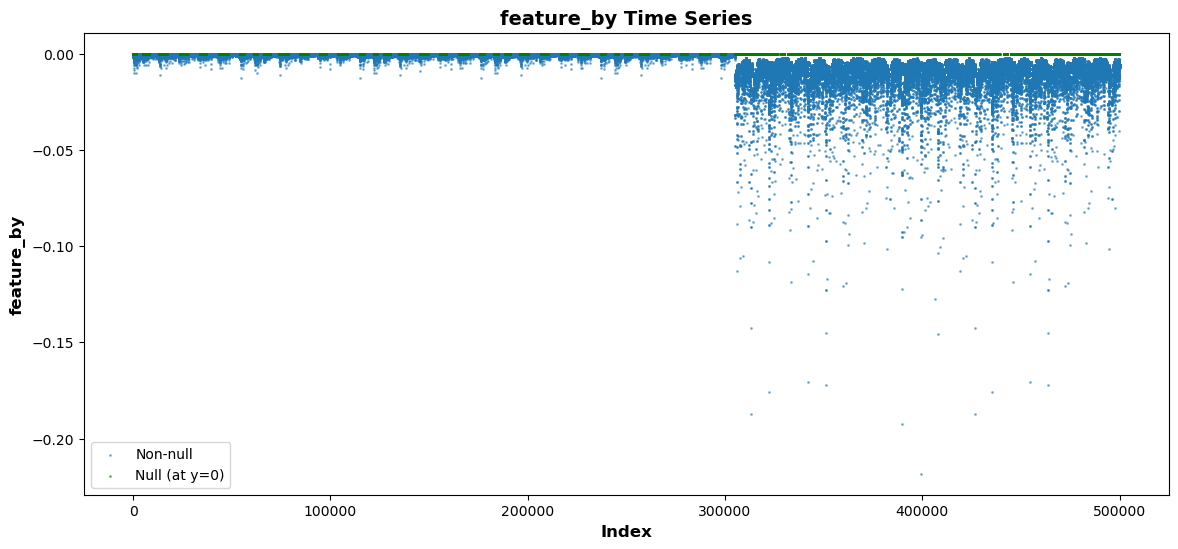

In [75]:
# Scatter plot of feature_by showing non-null and null values
feature_series = train_sample['feature_by']
non_null_indices = feature_series[feature_series.notna()].index
null_indices = feature_series[feature_series.isna()].index

plt.figure(figsize=(14, 6))
plt.scatter(non_null_indices, feature_series[non_null_indices].values, alpha=0.5, s=1, label='Non-null')
plt.scatter(null_indices, [0] * len(null_indices), alpha=0.5, s=1, color='green', label='Null (at y=0)')
plt.xlabel('Index', fontsize=12, fontweight='bold')
plt.ylabel('feature_by', fontsize=12, fontweight='bold')
plt.title('feature_by Time Series', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()


### Correlation Analysis for target prediction 

**Note: NaN values are ignored**

* Pearson (linear) correlation coefficient
* Spearman (monotonic) correlation coefficient 

Display heatmaps for correlations with absolute value between 0.4 and 1.0.

In [98]:
# Calculate Pearson (linear) and Spearman (monotonic) correlations

# Compare y_target with all numerical features (1-to-many relationship)
numerical_features = X_features.select_dtypes(include=[np.number])

# Remove 'horizon' from numerical features as it will be engineered separately
numerical_features = numerical_features.drop(columns=['horizon'])

print(f"Numerical features for dimensionality reduction: {numerical_features.shape}")
print(f"Excluded columns: ['horizon'] - will be engineered separately")

# Measure correlation between y_target and numerical features (absolute correlation between 0.1 and 1.0)
Features_correlation = analyze_target_correlation(
    features=numerical_features, 
    target=y_target, 
    feature_prefix='Feature',
    min_corr=0.1,
    max_corr=1.0
)

Numerical features for dimensionality reduction: (500000, 87)
Excluded columns: ['horizon'] - will be engineered separately
No meaningful correlations with y_target found in range [0.1, 1.0]


## Dimensionality Reduction

Apply PCA and t-SNE to reduce dimensionality and visualize patterns in the data.

In [99]:
from sklearn.decomposition import PCA

# User inputs: column indices for feature selection
start_col_idx = 0  # Start column index (inc lusive)
end_col_idx = numerical_features.shape[1] - 1  # End column index (inclusive)

# Select columns based on user-specified indices from numerical_features
selected_features = numerical_features.iloc[:, start_col_idx:end_col_idx+1]

# Handle missing values: fill with median for numerical columns
selected_features_clean = selected_features.fillna(selected_features.median())

# Standardize features (important for PCA and t-SNE)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(selected_features_clean)

print(f"Selected features: columns {start_col_idx} to {end_col_idx}")
print(f"Shape of selected features: {selected_features.shape}")
print(f"Number of features for dimensionality reduction: {selected_features.shape[1]}")


Selected features: columns 0 to 86
Shape of selected features: (500000, 87)
Number of features for dimensionality reduction: 87


### PCA - Principal Component Analysis

Perform PCA to identify the variance captured by each principal component.

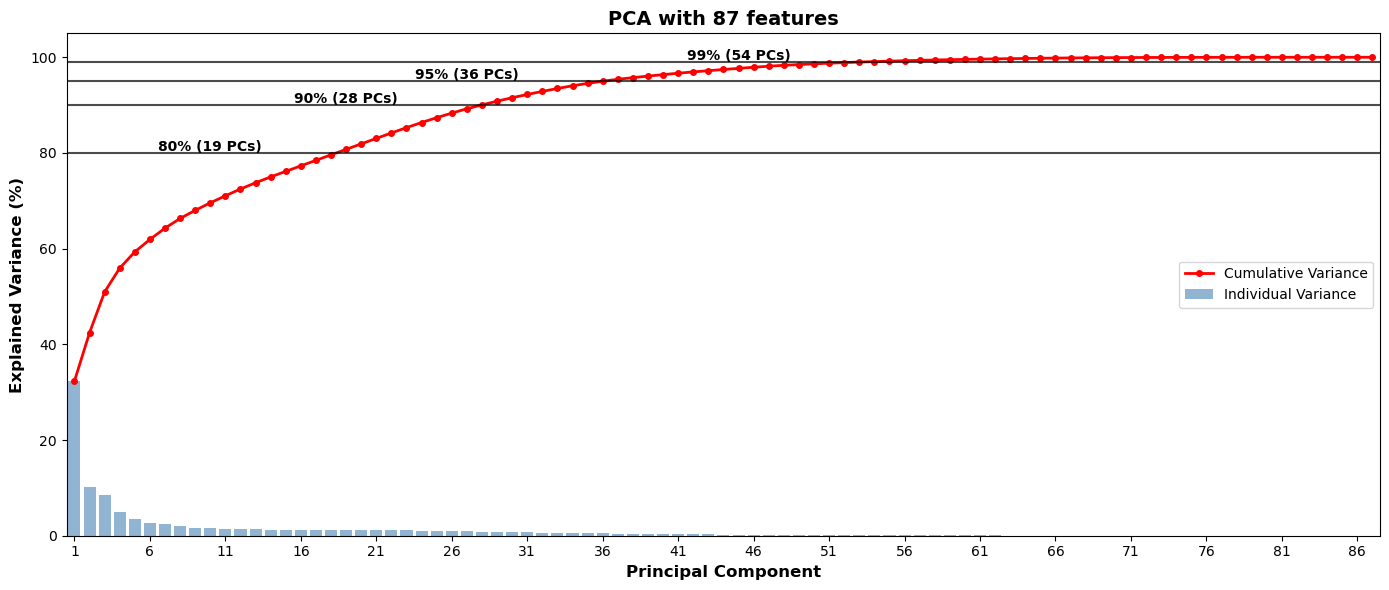

In [100]:
# Apply PCA to all selected features
pca = PCA()
pca_features = pca.fit_transform(features_scaled)

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create visualization of variance explained by each PC
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Bar plot with cumulative line
x_pos = np.arange(len(explained_variance))
ax.bar(x_pos, explained_variance * 100, alpha=0.6, color='steelblue', label='Individual Variance')
ax.plot(x_pos, cumulative_variance * 100, color='red', marker='o', linestyle='-', linewidth=2, markersize=4, label='Cumulative Variance')

# Formatting
ax.set_xlabel('Principal Component', fontsize=12, fontweight='bold')
ax.set_ylabel('Explained Variance (%)', fontsize=12, fontweight='bold')
ax.set_title(f'PCA with {end_col_idx + 1} features', 
             fontsize=14, fontweight='bold')
ax.legend(loc='center right', fontsize=10)

# Show x-axis tickers every 5 components, starting from 1
tick_positions = np.arange(0, len(explained_variance), 5)
tick_labels = np.arange(1, len(explained_variance) + 1, 5)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

# Adjust x-axis limits to start slightly left of 0 for uniform grouping
ax.set_xlim(-0.5, len(explained_variance) - 0.5)

# Add text annotations above black horizontal lines
for threshold in [0.80, 0.90, 0.95, 0.99]:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    if n_components > 0 and cumulative_variance[n_components-1] >= threshold:
        # Black horizontal line at threshold
        ax.axhline(y=threshold*100, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
        # Place black text annotation above the line
        ax.text(n_components - 10, threshold*100 + 0.5, 
                f'{int(threshold*100)}% ({n_components} PCs)', 
                fontsize=10, fontweight='bold', color='black',
                horizontalalignment='center')

plt.tight_layout()
plt.show()

### AutoEncoder

Apply AutoEncoder to capture non-linear relationships and reduce dimensionality with the 99% of data.

In [101]:
# Select number of PCA components that explain 99% variance
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
print(f"Number of PCA components for 99% variance: {n_components_99}")

# Use only the selected PCA components as input to autoencoder
pca_reduced = pca_features[:, :n_components_99]

# Split data for training and validation (last 20% as validation, no shuffle)
split_idx = int(len(pca_reduced) * 0.8)
X_train_ae = pca_reduced[:split_idx]
X_val_ae = pca_reduced[split_idx:]

print(f"Training set shape: {X_train_ae.shape}")
print(f"Validation set shape: {X_val_ae.shape}")

Number of PCA components for 99% variance: 54
Training set shape: (400000, 54)
Validation set shape: (100000, 54)


In [102]:
# Define autoencoder architecture
# Shallow, symmetric autoencoder with single bottleneck layer

input_dim = n_components_99
encoding_dim = 27  # Bottleneck dimension

# Encoder
encoder_input = keras.Input(shape=(input_dim,))
encoded = Dense(encoding_dim * 2, activation='relu')(encoder_input)
encoded = Dropout(0.1)(encoded)  # Light regularization
encoded = Dense(encoding_dim, activation='relu')(encoded)  # Bottleneck layer

# Decoder (symmetric structure)
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)  # Reconstruct input

# Autoencoder model
autoencoder = keras.Model(encoder_input, decoded, name='autoencoder')

# Encoder model (for extracting latent representations)
encoder = keras.Model(encoder_input, encoded, name='encoder')

# Compile autoencoder with MSE loss and Adam optimizer
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
print("\n=== Autoencoder Architecture ===")
autoencoder.summary()
print(f"\nInput dimension: {input_dim}")
print(f"Bottleneck dimension: {encoding_dim}")
print(f"Compression ratio: {encoding_dim/input_dim:.2%}")


=== Autoencoder Architecture ===


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 54)             │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │         1,485 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 54)             │         1,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 54)             │         2,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,937 (34.91 KB)

 Trainable params: 8,937 (34.91 KB)

 Non-trainable params: 0 (0.00 B)


Input dimension: 54
Bottleneck dimension: 27
Compression ratio: 50.00%


In [103]:
# Train the autoencoder
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = autoencoder.fit(
    X_train_ae, X_train_ae,  # Input and target are the same (reconstruction)
    epochs=100,
    batch_size=256,
    validation_data=(X_val_ae, X_val_ae),
    callbacks=[early_stopping],
    verbose=1
)

print("\n=== Training Complete ===")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3582 - mae: 0.3924 - val_loss: 0.3027 - val_mae: 0.3762
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1884 - mae: 0.2997 - val_loss: 0.2160 - val_mae: 0.3226
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1625 - mae: 0.2779 - val_loss: 0.1785 - val_mae: 0.2844
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1479 - mae: 0.2641 - val_loss: 0.1477 - val_mae: 0.2627
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1384 - mae: 0.2538 - val_loss: 0.1353 - val_mae: 0.2505
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1330 - mae: 0.2472 - val_loss: 0.1312 - val_mae: 0.2465
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1288 - mae: 0.2423 - val_loss: 0.1290 - val_mae: 0.2427
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1253 - mae: 0.2381 - val_loss: 0.1176 - val_mae: 0.2322
Epoch 9/100
1563/1563 ━━━━━━━━━━

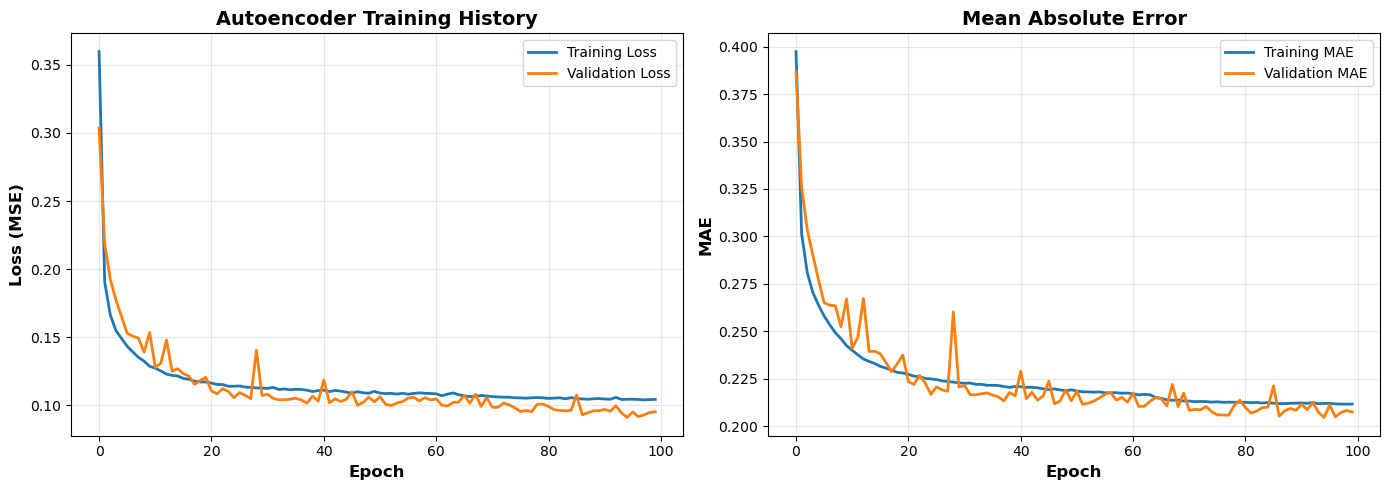

In [13]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_title('Autoencoder Training History', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [104]:
# Extract latent representations (encoded features)
latent_representation = encoder.predict(pca_reduced, verbose=0)

# Evaluate reconstruction quality
reconstructed = autoencoder.predict(pca_reduced, verbose=0)
mse = np.mean((pca_reduced - reconstructed) ** 2)
mae = np.mean(np.abs(pca_reduced - reconstructed))

print(f"\n=== Reconstruction Quality ===")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")

# Calculate correlation between original and reconstructed data
correlations = [np.corrcoef(pca_reduced[:, i], reconstructed[:, i])[0, 1] 
                for i in range(pca_reduced.shape[1])]
mean_correlation = np.mean(correlations)

print(f"Mean feature correlation: {mean_correlation:.4f}")


=== Reconstruction Quality ===
MSE: 0.055359
MAE: 0.160475
Mean feature correlation: 0.9024


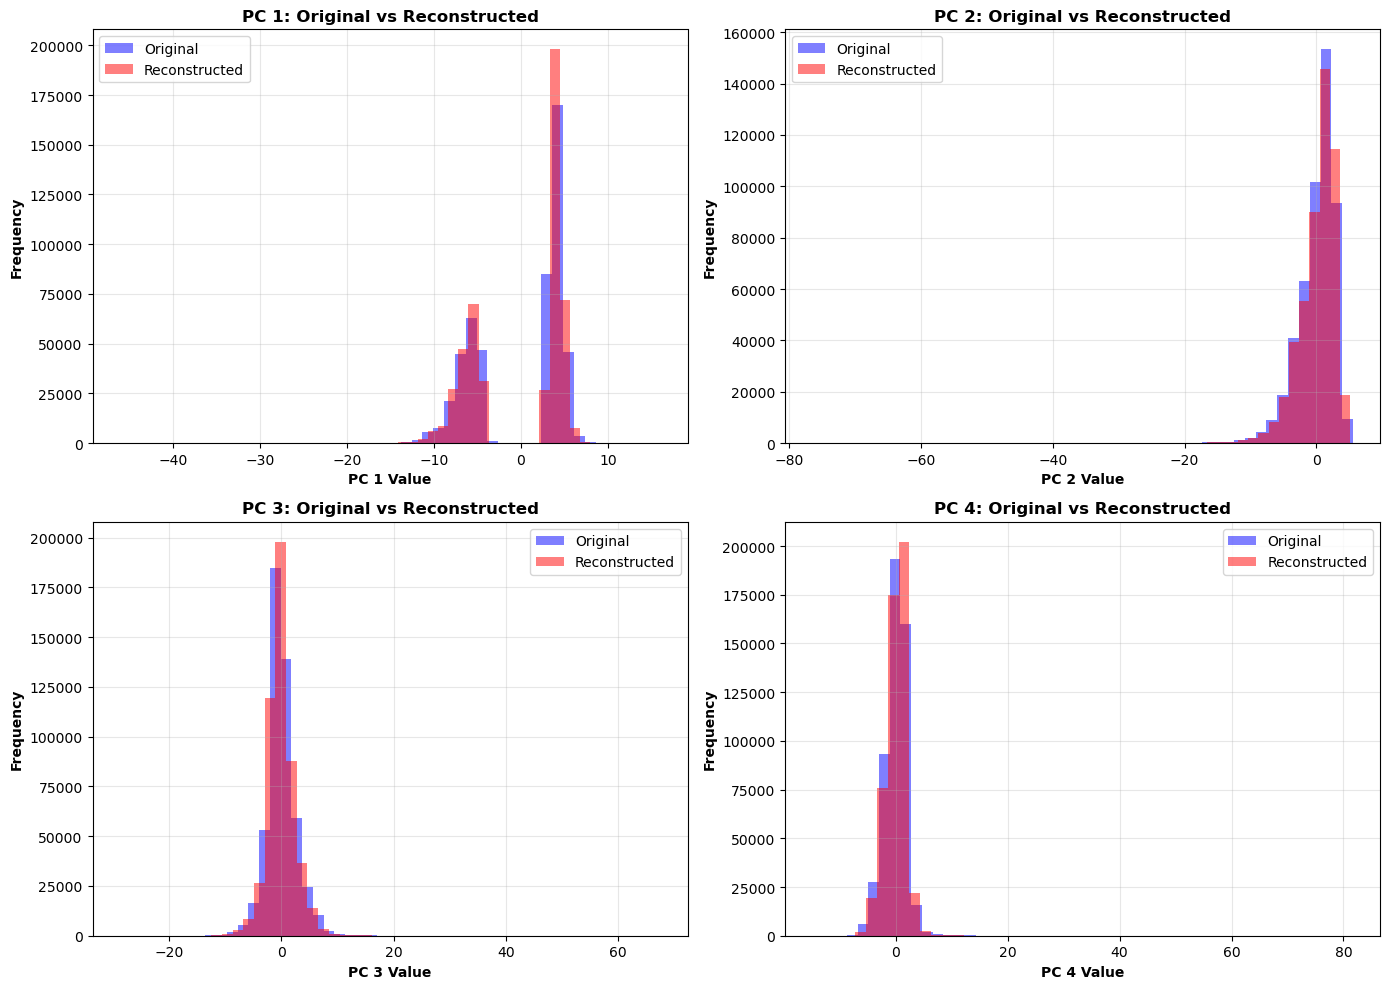

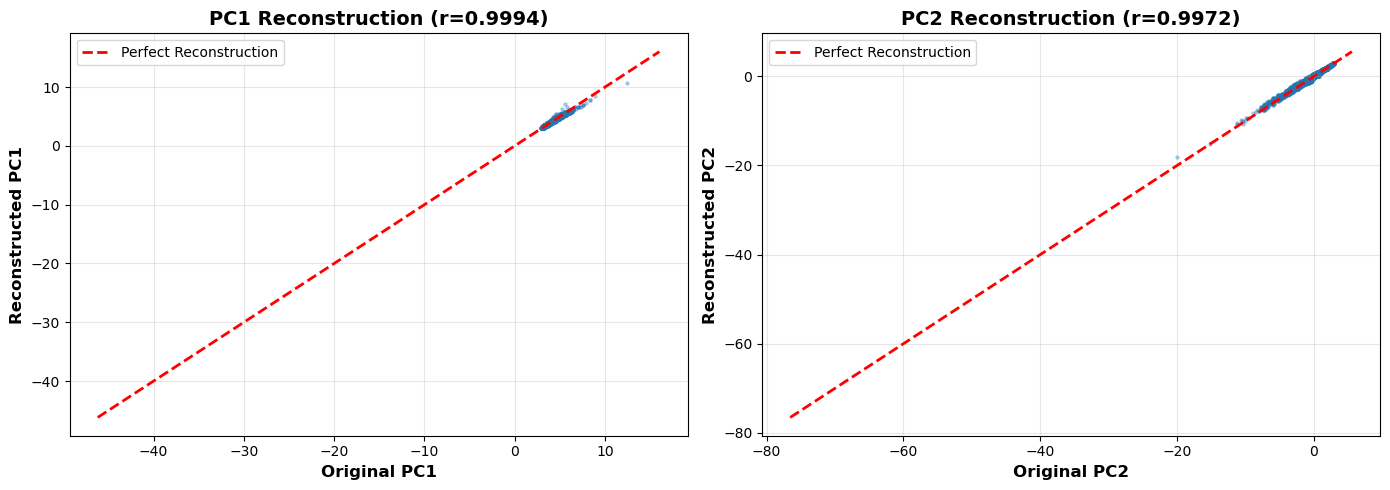

In [15]:
# Visualize reconstruction quality
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Distribution comparison for first few components
n_components_to_plot = min(4, pca_reduced.shape[1])
for i in range(n_components_to_plot):
    row = i // 2
    col = i % 2
    
    axes[row, col].hist(pca_reduced[:, i], bins=50, alpha=0.5, label='Original', color='blue')
    axes[row, col].hist(reconstructed[:, i], bins=50, alpha=0.5, label='Reconstructed', color='red')
    axes[row, col].set_xlabel(f'PC {i+1} Value', fontsize=10, fontweight='bold')
    axes[row, col].set_ylabel('Frequency', fontsize=10, fontweight='bold')
    axes[row, col].set_title(f'PC {i+1}: Original vs Reconstructed', fontsize=12, fontweight='bold')
    axes[row, col].legend()
    axes[row, col].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Scatter plot of original vs reconstructed for selected components
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First principal component
axes[0].scatter(pca_reduced[:5000, 0], reconstructed[:5000, 0], alpha=0.3, s=5)
axes[0].plot([pca_reduced[:, 0].min(), pca_reduced[:, 0].max()], 
             [pca_reduced[:, 0].min(), pca_reduced[:, 0].max()], 
             'r--', linewidth=2, label='Perfect Reconstruction')
axes[0].set_xlabel('Original PC1', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Reconstructed PC1', fontsize=12, fontweight='bold')
axes[0].set_title(f'PC1 Reconstruction (r={correlations[0]:.4f})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Second principal component
axes[1].scatter(pca_reduced[:5000, 1], reconstructed[:5000, 1], alpha=0.3, s=5)
axes[1].plot([pca_reduced[:, 1].min(), pca_reduced[:, 1].max()], 
             [pca_reduced[:, 1].min(), pca_reduced[:, 1].max()], 
             'r--', linewidth=2, label='Perfect Reconstruction')
axes[1].set_xlabel('Original PC2', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Reconstructed PC2', fontsize=12, fontweight='bold')
axes[1].set_title(f'PC2 Reconstruction (r={correlations[1]:.4f})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Correlation Analysis with Latent Features

Analyze the correlation between the autoencoder's latent representations and y_target.

In [16]:
# Apply correlation analysis to latent representation from autoencoder
latent_correlations = analyze_target_correlation(
    features=latent_representation, 
    target=y_target, 
    feature_prefix='Latent',
    min_corr=0.1,
    max_corr=1.0
)

No meaningful correlations with y_target found in range [0.1, 1.0]


## Feature Engineering

In [106]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Start with latent representation from autoencoder as base features
# latent_representation shape: (500000, 27) - 27 encoded features from PCA+autoencoder
latent_feature_names = [f'latent_{i+1}' for i in range(latent_representation.shape[1])]
X_engineered = pd.DataFrame(
    latent_representation,
    columns=latent_feature_names,
    index=X_features.index
)

# Now add engineered features from categorical/discrete columns that were NOT used in dimensionality reduction

# 1. Horizon mapping (excluded from PCA, so we engineer it here)
horizon_mapping = {1: 1, 3: 2, 10: 3, 25: 4}
X_engineered['horizon_mapped'] = X_features['horizon'].map(horizon_mapping).fillna(0)

# 2. One-hot encoding for 'code' column (drop first column)
code_encoder = OneHotEncoder(drop='first', sparse_output=False)
code_encoded = code_encoder.fit_transform(X_features[['code']])
code_encoded_df = pd.DataFrame(
    code_encoded, 
    columns=[f'code_{cat}' for cat in code_encoder.categories_[0][1:]],
    index=X_features.index
)

# 3. One-hot encoding for 'sub_category' (drop first column)
subcategory_encoder = OneHotEncoder(drop='first', sparse_output=False)
subcategory_encoded = subcategory_encoder.fit_transform(X_features[['sub_category']])
subcategory_encoded_df = pd.DataFrame(
    subcategory_encoded,
    columns=[f'sub_category_{cat}' for cat in subcategory_encoder.categories_[0][1:]],
    index=X_features.index
)

# 4. Frequency encoding for 'sub_category'
subcategory_freq = X_features['sub_category'].value_counts()
X_engineered['sub_category_freq'] = X_features['sub_category'].map(subcategory_freq).fillna(0)

# 5. Frequency encoding for 'sub_code'
subcode_freq = X_features['sub_code'].value_counts()
X_engineered['sub_code_freq'] = X_features['sub_code'].map(subcode_freq).fillna(0)

# 6. Add 'id' column (may be useful for grouping/aggregation)
X_engineered['id'] = X_features['id']

# Concatenate all engineered features
X_engineered = pd.concat([X_engineered, code_encoded_df, subcategory_encoded_df], axis=1)

print(f"Feature Engineering Summary:")
print(f"=" * 60)
print(f"Base features: {len(latent_feature_names)} latent features from autoencoder")
print(f"\nAdded categorical/discrete feature engineering:")
print(f"  - horizon_mapped: numerical mapping [1→1, 3→2, 10→3, 25→4]")
print(f"  - code one-hot: {list(code_encoded_df.columns)}")
print(f"  - sub_category one-hot: {list(subcategory_encoded_df.columns)}")
print(f"  - sub_category_freq: frequency encoding (NA filled with 0)")
print(f"  - sub_code_freq: frequency encoding (NA filled with 0)")
print(f"  - id: original id column")

print(f"\nFinal shape: {X_engineered.shape}")
print(f"Total features: {X_engineered.shape[1]}")

display(X_engineered.head())

Feature Engineering Summary:
Base features: 27 latent features from autoencoder
  (These capture: ts_index and all feature_* columns)

Added categorical/discrete feature engineering:
  - horizon_mapped: numerical mapping [1→1, 3→2, 10→3, 25→4]
  - code one-hot: ['code_W2MW3G2L']
  - sub_category one-hot: ['sub_category_NQ58FVQM', 'sub_category_PHHHVYZI', 'sub_category_PZ9S1Z4V', 'sub_category_V8BKY1IV']
  - sub_category_freq: frequency encoding (NA filled with 0)
  - sub_code_freq: frequency encoding (NA filled with 0)
  - id: original id column

Final shape: (500000, 36)
Total features: 36


,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,latent_10,...,latent_27,horizon_mapped,sub_category_freq,sub_code_freq,id,code_W2MW3G2L,sub_category_NQ58FVQM,sub_category_PHHHVYZI,sub_category_PZ9S1Z4V,sub_category_V8BKY1IV
0,4.662201,1.352757,1.861356,2.337854,0.0,2.904424,0.0,3.131186,3.446060,3.928349,...,2.992208,4,174674,1887,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__25__89,1.0,0.0,0.0,1.0,0.0
1,4.217045,1.285978,1.782837,2.325305,0.0,3.391361,0.0,2.707854,4.519444,3.651589,...,2.971414,1,174674,1887,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__1__89,1.0,0.0,0.0,1.0,0.0
2,3.786767,1.590915,1.652064,2.635067,0.0,3.312856,0.0,3.474616,4.253521,4.102463,...,2.610177,2,174674,1887,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__3__89,1.0,0.0,0.0,1.0,0.0
3,4.541092,1.613401,1.809228,2.000607,0.0,3.140568,0.0,2.963610,3.492872,3.930499,...,3.261508,3,174674,1887,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__10__89,1.0,0.0,0.0,1.0,0.0
4,5.406447,1.487830,2.310427,3.034678,0.0,2.916929,0.0,4.000770,6.440639,4.210200,...,3.775880,4,174674,1887,W2MW3G2L__J0G2B0KU__PZ9S1Z4V__25__90,1.0,0.0,0.0,1.0,0.0


## Forecasting with XGBoost Random Forest Regressor

Use the engineered features (latent + categorical features) to predict y_target with XGBRFRegressor.

In [119]:
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split the engineered features and target according to the same train/val split
# Use the same split_idx that was used for the autoencoder training
y_train = y_target.iloc[:split_idx]
y_val = y_target.iloc[split_idx:]

# Get engineered features for train and validation sets
# Remove 'id' column as it's not useful for prediction
X_train = X_engineered.iloc[:split_idx].drop(columns=['id'])
X_val = X_engineered.iloc[split_idx:].drop(columns=['id'])

print(f"=== Data Split (Sequential, No Shuffle) ===")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Validation target shape: {y_val.shape}")
print(f"\nFeatures used: {X_train.shape[1]} (27 latent + 8 engineered categorical/discrete)")

# Initialize and train XGBRFRegressor
xgbrf_model = XGBRFRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bynode=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=1
)

print("\n=== Training XGBRFRegressor ===")
xgbrf_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

=== Data Split (Sequential, No Shuffle) ===
Training samples: 400000
Validation samples: 100000
Training features shape: (400000, 35)
Validation features shape: (100000, 35)
Training target shape: (400000,)
Validation target shape: (100000,)

Features used: 35 (27 latent + 8 engineered categorical/discrete)

=== Training XGBRFRegressor (Only on Training Data) ===


=== Data Split (Sequential, No Shuffle) ===
Training samples: 400000
Validation samples: 100000
Training features shape: (400000, 35)
Validation features shape: (100000, 35)
Training target shape: (400000,)
Validation target shape: (100000,)

Features used: 35 (27 latent + 8 engineered categorical/discrete)

=== Training XGBRFRegressor (Only on Training Data) ===


,learning_rate,0.1
,subsample,0.8
,colsample_bynode,0.8
,reg_lambda,1e-05
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bytree,None
,device,None


In [120]:
# Make predictions on both training and validation sets
y_train_pred = xgbrf_model.predict(X_train)
y_val_pred = xgbrf_model.predict(X_val)

# Calculate regression metrics for training set
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate regression metrics for validation set
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("\n=== Model Performance Metrics ===")
print("\nTraining Set:")
print(f"  MAE: {train_mae:.6f}")
print(f"  MSE: {train_mse:.6f}")
print(f"  R²:  {train_r2:.6f}")

print("\nValidation Set:")
print(f"  MAE: {val_mae:.6f}")
print(f"  MSE: {val_mse:.6f}")
print(f"  R²:  {val_r2:.6f}")

# Calculate percentage metrics
print("\n=== Additional Metrics ===")
train_mape = np.mean(np.abs((y_train - y_train_pred) / np.where(y_train != 0, y_train, 1))) * 100
val_mape = np.mean(np.abs((y_val - y_val_pred) / np.where(y_val != 0, y_val, 1))) * 100
print(f"Training MAPE: {train_mape:.2f}%")
print(f"Validation MAPE: {val_mape:.2f}%")


=== Making Predictions ===
Training predictions: 400000
Validation predictions: 100000

=== Model Performance Metrics ===

Training Set:
  MAE: 0.384298
  MSE: 0.660438
  R²:  0.014369

Validation Set:
  MAE: 0.612246
  MSE: 1.032317
  R²:  -0.011502

=== Additional Metrics ===
Training MAPE: 401545911335.04%
Validation MAPE: 167.58%


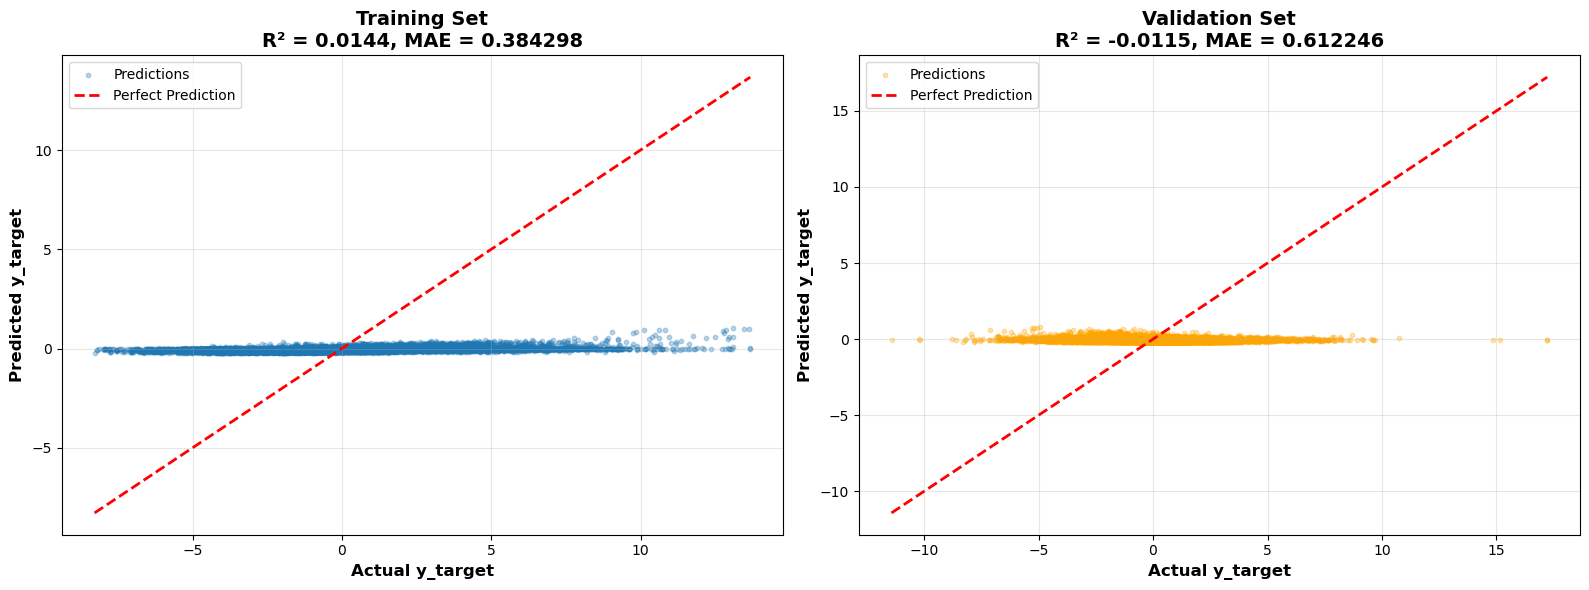

In [121]:
# Visualize predictions vs actual values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set predictions
axes[0].scatter(y_train, y_train_pred, alpha=0.3, s=10, label='Predictions')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual y_target', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted y_target', fontsize=12, fontweight='bold')
axes[0].set_title(f'Training Set\nR² = {train_r2:.4f}, MAE = {train_mae:.6f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Validation set predictions
axes[1].scatter(y_val, y_val_pred, alpha=0.3, s=10, label='Predictions', color='orange')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual y_target', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted y_target', fontsize=12, fontweight='bold')
axes[1].set_title(f'Validation Set\nR² = {val_r2:.4f}, MAE = {val_mae:.6f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

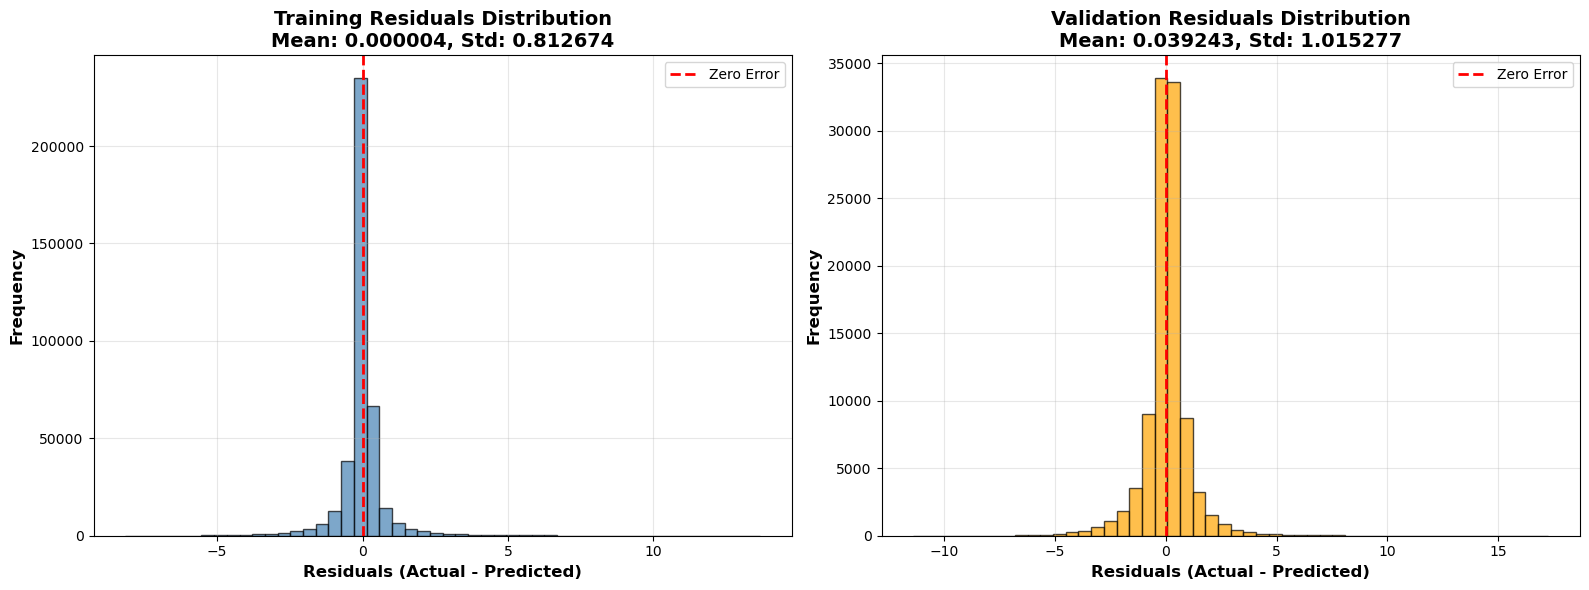

In [122]:
# Plot residuals distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training residuals
train_residuals = y_train - y_train_pred
axes[0].hist(train_residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title(f'Training Residuals Distribution\nMean: {train_residuals.mean():.6f}, Std: {train_residuals.std():.6f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Validation residuals
val_residuals = y_val - y_val_pred
axes[1].hist(val_residuals, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title(f'Validation Residuals Distribution\nMean: {val_residuals.mean():.6f}, Std: {val_residuals.std():.6f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

=== Top 10 Most Important Features ===
       Feature  Importance
      latent_7    0.067745
     latent_15    0.067650
     latent_16    0.064732
horizon_mapped    0.063099
     latent_23    0.042426
     latent_17    0.042032
     latent_14    0.034925
      latent_5    0.034378
     latent_24    0.034378
     latent_27    0.034281


=== Top 10 Most Important Features ===
       Feature  Importance
      latent_7    0.067745
     latent_15    0.067650
     latent_16    0.064732
horizon_mapped    0.063099
     latent_23    0.042426
     latent_17    0.042032
     latent_14    0.034925
      latent_5    0.034378
     latent_24    0.034378
     latent_27    0.034281


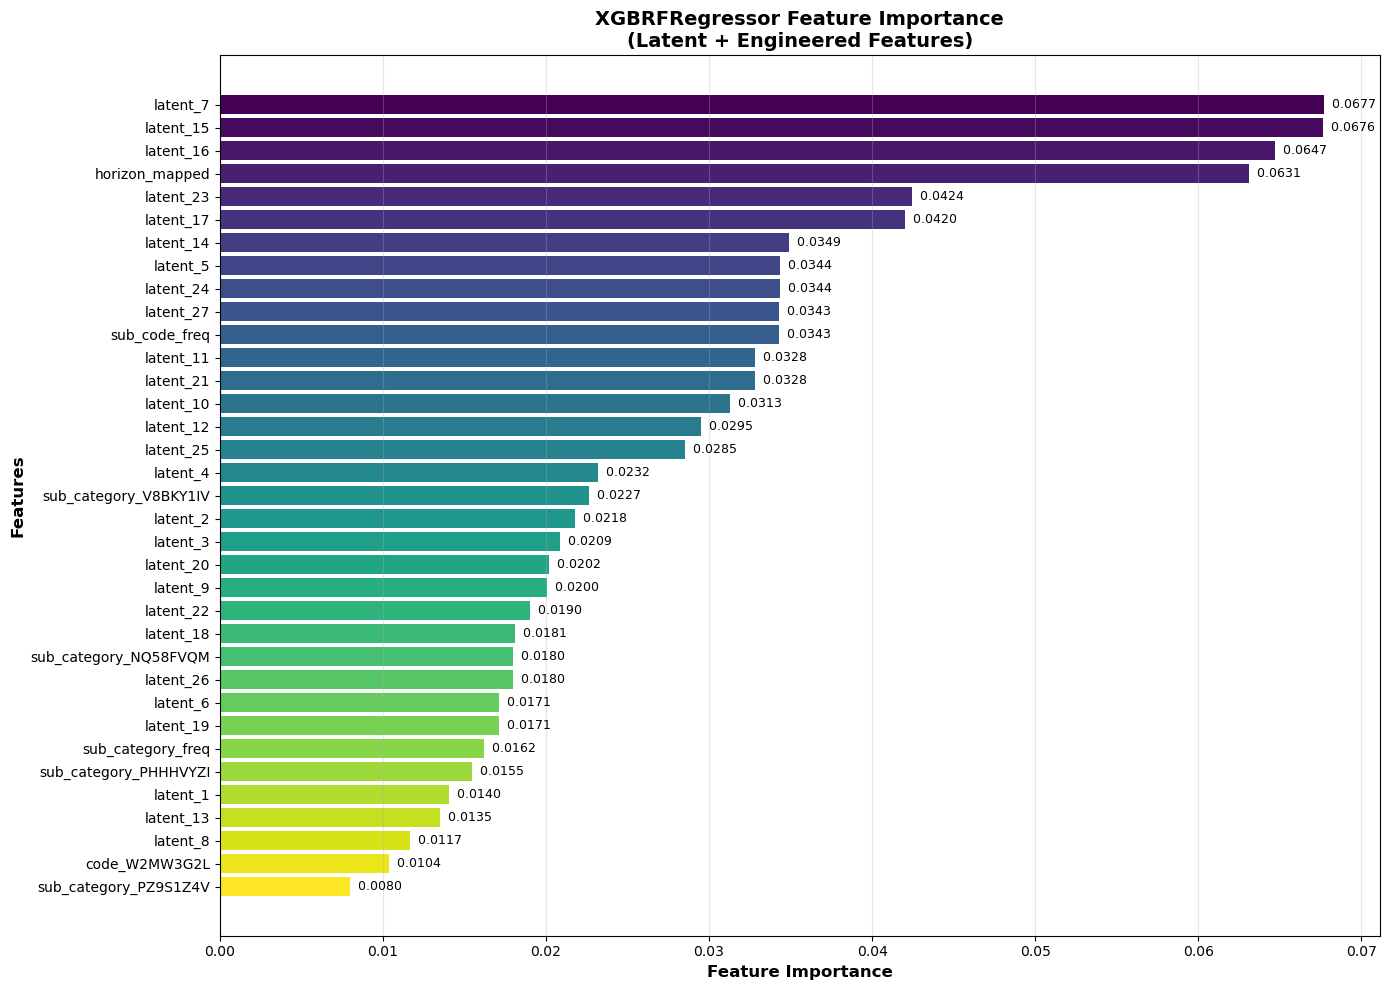

In [123]:
# Feature importance from XGBRFRegressor
feature_importance = xgbrf_model.feature_importances_
feature_names = X_train.columns.tolist()

# Create DataFrame for easier manipulation
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("=== Top 10 Most Important Features ===")
print(importance_df.head(10).to_string(index=False))

# Plot feature importance
fig, ax = plt.subplots(figsize=(14, 10))

# Plot all features
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
bars = ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors)

ax.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.set_title('XGBRFRegressor Feature Importance\n(Latent + Engineered Features)', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()  # Highest importance at the top
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (idx, row) in enumerate(importance_df.iterrows()):
    ax.text(row['Importance'], i, f"  {row['Importance']:.4f}", 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

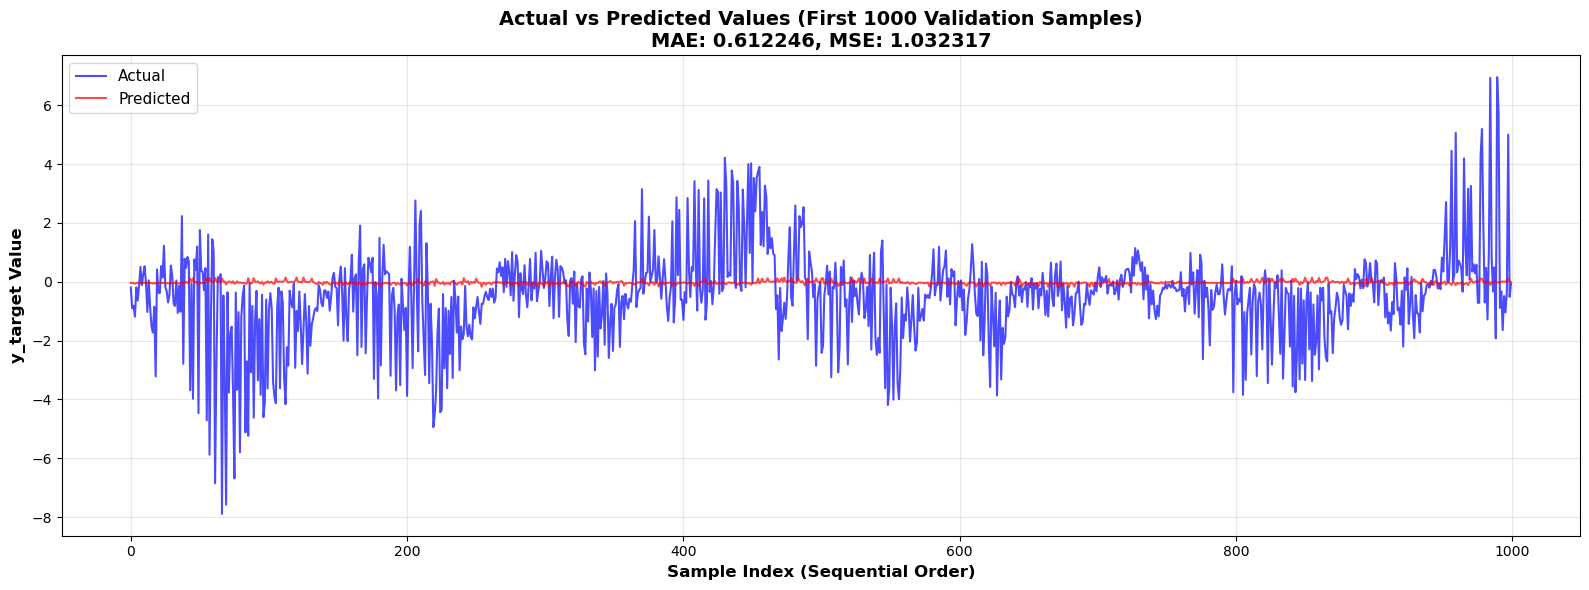


=== Summary ===
Model: XGBRFRegressor
Input features: 35 (27 latent + 8 engineered)
Training samples: 400000
Validation samples: 100000
Validation MAE: 0.612246
Validation MSE: 1.032317
Validation R²: -0.011502
Validation R²: -0.011502


In [124]:
# Time series plot of actual vs predicted values (first 1000 validation samples)
n_samples_to_plot = min(1000, len(y_val))
indices = np.arange(n_samples_to_plot)

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(indices, y_val.iloc[:n_samples_to_plot].values, 
        label='Actual', linewidth=1.5, alpha=0.7, color='blue')
ax.plot(indices, y_val_pred[:n_samples_to_plot], 
        label='Predicted', linewidth=1.5, alpha=0.7, color='red')

ax.set_xlabel('Sample Index (Sequential Order)', fontsize=12, fontweight='bold')
ax.set_ylabel('y_target Value', fontsize=12, fontweight='bold')
ax.set_title(f'Actual vs Predicted Values (First {n_samples_to_plot} Validation Samples)\nMAE: {val_mae:.6f}, MSE: {val_mse:.6f}', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== Summary ===")
print(f"Model: XGBRFRegressor")
print(f"Input features: {X_train.shape[1]} ({len(latent_feature_names)} latent + {X_train.shape[1] - len(latent_feature_names)} engineered)")
print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")
print(f"Validation MAE: {val_mae:.6f}")
print(f"Validation MSE: {val_mse:.6f}")
print(f"Validation R²: {val_r2:.6f}")
print(f"Validation R²: {val_r2:.6f}")